# Image Similarity

This project is based on Image Similarity. Basically, it returns user all(custom) of the images it found similar to the query image. I learned a lot of new things while completing this. I came to know about FAST.AI that is making life easier for DL practitioners. I used Fast.AI to accomplish transfer learning from RESNET34 CNN. RESNET34 is originally trained on CIFAR-10 dataset. I initially retrained the last layer of the model on CALTECH101 dataset and then retrained all previous layers to get accuracy of 94.6%. Next, I created Forward Hook to store embeddings of all the images in CALTECH101 dataset(9000+ images). Using Locality Sensitivity Hashing, I wrote a small script to return the user similar images it found to the query image.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import pickle
import numpy as np
# %pip install lshash3 fastai

from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
from lshash import *
from PIL import Image
from tqdm import tqdm_notebook

pd.set_option('display.max_columns', 500)

### 1. Transfer Learning using FAST.AI

In [7]:
path = Path('../CV_Datasets/Caltech101/')

In [ ]:
# No Tabcransformations required
tfms = get_transforms(do_flip=False,
                     flip_vert = False,
                     max_rotate = 0, max_lighting=0, max_zoom=1,
                      max_warp = 0)

data = (ImageList.from_folder(path).split_by_rand_pct(0.2).label_from_folder().transform(tfms=tfms, size=224).databunch(bs=64))

In [9]:
print('Number of classes {0}'.format(data.c))

Number of classes 102


In [6]:
print('Train Dataset Size: {}'.format(len(data.train_ds.x)))
print('Test Dataset Size: {}'.format(len(data.valid_ds.x)))

Train Dataset Size: 7316
Test Dataset Size: 1829


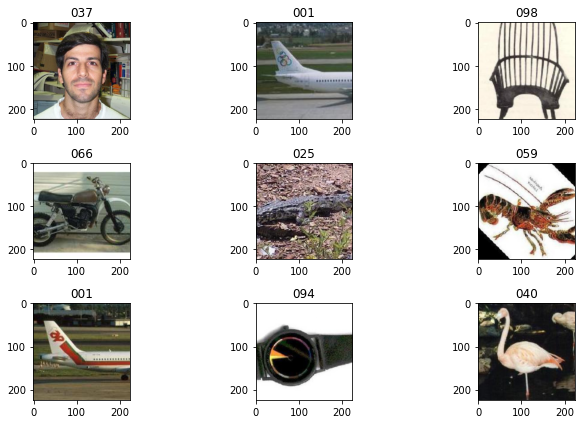

In [11]:
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [12]:
# help(models.resnet34)
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=accuracy)

In [ ]:
learn.lr_find()

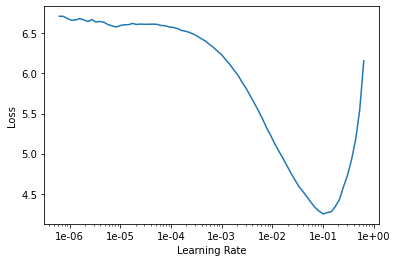

In [10]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

In [12]:
learn.save('stage1-rn34')

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, 1e-2/5))

In [15]:
learn.save('stage2-rn34')

### 2. Extracting Image Embeddings through Forward Hooks

In [16]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

In [ ]:
## By running this feature vectors would be saved in sf variable initated above
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [19]:
img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features))

In [20]:
pickle.dump(feature_dict, open(path/"feature_dict.p", "wb"))

### 3. Create Locality Sensitivity Hashing

In [21]:
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))

In [ ]:
from lshashpy3 import LSHash
## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=img_path)

In [24]:
pickle.dump(lsh, open(path/'lsh.p', "wb"))

### 4. Show Similar Images

In [39]:

## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))
lsh = pickle.load(open(path/'lsh.p','rb'))

def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[max(9140 - idx*500, 9140 - idx)]].flatten(), 
                     num_results=n_items+1, distance_func='hamming')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    return plt.show()

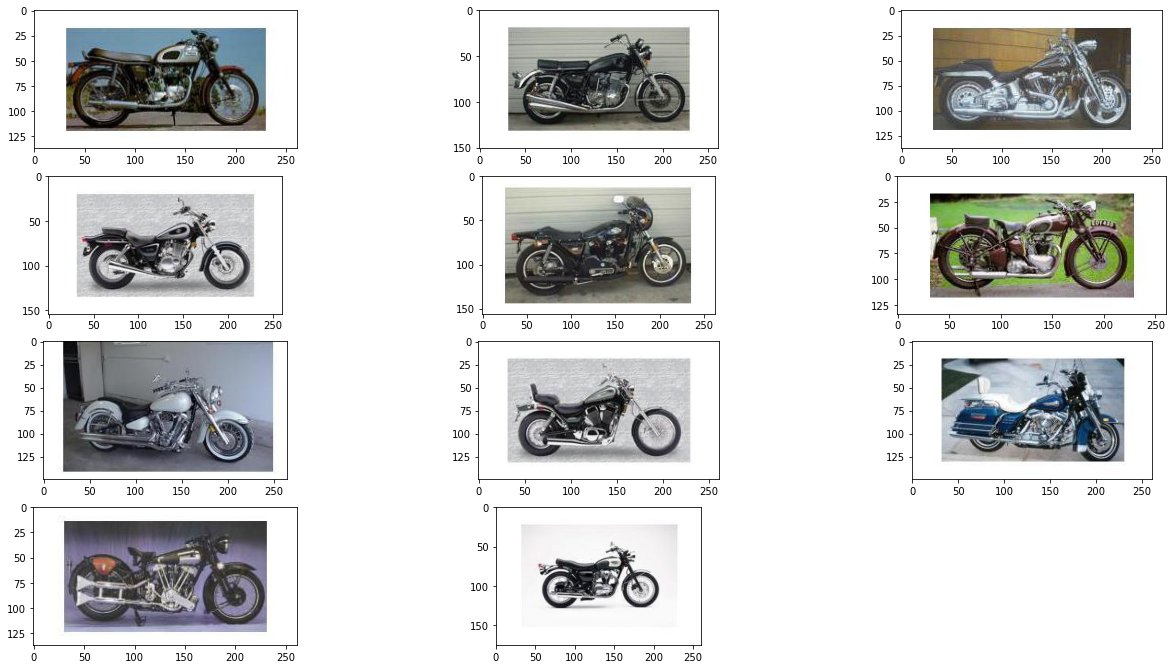

In [60]:
get_similar_item(284, feature_dict, lsh, 10)